# T013 · Data acquisition (KLIFS)

Authors:

- Jaime Rodríguez-Guerra, 2019-2020, [Volkamer lab, Charité](https://volkamerlab.org/)
- Dominique Sydow, 2019-2020, [Volkamer lab, Charité](https://volkamerlab.org/)

## Aim of this talktorial

We will query the KLIFS database to obtain a kinase structure and one inhibitor.

### Contents in *Theory*

- KLIFS

### Contents in *Practical*

- Write the functions that will compose the pipeline
- Case study: EGFR inhibitors

### References

* KLIFS, a kinase-inhibitor interactions database.
   * Description of the database itself ([_J. Med. Chem._ (2014), __57__, 2, 249-277](https://pubs.acs.org/doi/abs/10.1021/jm400378w))
   * Description of the online service ([_Nucleic Acids Res._ (2016), __44__, 6, D365–D371](https://doi.org/10.1093/nar/gkv1082))
* NGLView, the interactive visualizer for the Notebook ([_Bioinformatics_ (2018), __34__, 1241–124](https://doi.org/10.1093/bioinformatics/btx789))

## Theory

**TODO** Update! 

Kinase-Ligand Interaction Fingerprints and Structures database (KLIFS), developed at the Division of Medicinal Chemistry - VU University Amsterdam, is a database that provides information about the protein structure (collected from the PDB) of catalytic kinase domains and the interaction with their ligands. We can obtain the curated protein structure from this database and use the ligand information to retrieve similar ligands from other databases, like PubChem or ChEMBL.

### KLIFS

* Role: Kinase-ligand interaction profiles database
* Website: http://klifs.vu-compmedchem.nl/
* API: Yes, REST-based, Swagger-enabled. No official client. Use `bravado`.
* Documentation: http://klifs.vu-compmedchem.nl/swagger/
* Literature:
   * Description of the database itself ([_J. Med. Chem._ (2014), __57__, 2, 249-277](https://pubs.acs.org/doi/abs/10.1021/jm400378w))
   * Description of the online service ([_Nucleic Acids Res._ (2016), __44__, 6, D365–D371](https://doi.org/10.1093/nar/gkv1082))
    

> Kinase-Ligand Interaction Fingerprints and Structures database (KLIFS), developed at the Division of Medicinal Chemistry - VU University Amsterdam, is a database that revolves around the protein structure of catalytic kinase domains and the way kinase inhibitors can interact with them. Based on the underlying systematic and consistent protocol all (currently human and mouse) kinase structures and the binding mode of kinase ligands can be directly compared to each other. Moreover, because of the classification of an all-encompassing binding site of 85 residues it is possible to compare the interaction patterns of kinase-inhibitors to each other to, for example, identify crucial interactions determining kinase-inhibitor selectivity.

## Practical

### Obtaining information from KLIFS

Choose a random kinase from a random family (in `mol2`) and the corresponding ligands (`SMILES`) from the KLIFS database. We will also obtain the PDB structure of the protein-ligand complex so we can calculate the binding pockets in part B.

In [1]:
from bravado.client import SwaggerClient

KLIFS_API_DEFINITIONS = "https://klifs.net/swagger/swagger.json"
KLIFS_CLIENT = SwaggerClient.from_url(KLIFS_API_DEFINITIONS, config={"validate_responses": False})

In [2]:
def _all_kinase_families():
    return KLIFS_CLIENT.Information.get_kinase_families().response().result


def _kinases_from_family(family, species="HUMAN"):
    return (
        KLIFS_CLIENT.Information.get_kinase_names(kinase_family=family, species=species)
        .response()
        .result
    )


def _protein_and_ligand_structure(*kinase_ids):
    structures = (
        KLIFS_CLIENT.Structures.get_structures_list(kinase_ID=kinase_ids).response().result
    )
    molcomplex = (
        KLIFS_CLIENT.Structures.get_structure_get_pdb_complex(
            structure_ID=structures[0].structure_ID
        )
        .response()
        .result
    )
    protein = (
        KLIFS_CLIENT.Structures.get_structure_get_protein(structure_ID=structures[0].structure_ID)
        .response()
        .result
    )
    ligands = KLIFS_CLIENT.Ligands.get_ligands_list(kinase_ID=kinase_ids).response().result
    print(
        f"Chosen KLIFS entry with PDB ID {structures[0].pdb} with chain {structures[0].chain} and alternate model {structures[0].alt}"
    )
    return molcomplex, protein, [ligand.SMILES for ligand in ligands]

In [3]:
import random
import time


def random_kinase_structure():
    """
    Get a random kinase from a random family
    """
    attempts = 20
    families = _all_kinase_families()
    while attempts:  # some kinase IDs do not have a structure available
        family = random.choice(families)
        kinase = random.choice(_kinases_from_family(family))
        try:
            molcomplex, protein, ligands = _protein_and_ligand_structure(kinase.kinase_ID)
        except:
            attempts -= 1
            time.sleep(1)
        else:
            print(
                "Chosen",
                kinase.name,
                "kinase with ID",
                kinase.kinase_ID,
                "from family",
                family,
            )
            return molcomplex, protein, ligands
    print("Could not find a valid kinase. Try again!")
    return None, None, None


def kinase_structure_from_family(family):
    """
    Given a kinase family name (check `_all_kinase_families()`), retrieve a random structure.
    """
    attempts = 20
    while attempts:  # some kinase IDs cannot be found in the structure list...
        kinase = random.choice(_kinases_from_family(family))
        try:
            molcomplex, protein, ligands = _protein_and_ligand_structure(kinase.kinase_ID)
        except:
            attempts -= 1
            time.sleep(1)
        else:
            print(
                "Chosen",
                kinase.name,
                "kinase with ID",
                kinase.kinase_ID,
                "from family",
                family,
            )
            return molcomplex, protein, ligands
    print("Could not find a valid kinase. Try again!")
    return None, None, None

Let's check if this works. Let's say you want a random kinase from a random family, you can use `random_kinase_structure()` like this:

In [4]:
molcomplex, protein, ligands = random_kinase_structure()

Chosen KLIFS entry with PDB ID 5l6p with chain A and alternate model 
Chosen EPHB3 kinase with ID 419 from family Eph


In [5]:
ligands

['O=C(Nc1cc2ncnc(Nc3ccccc3)c2cc1)C', 'O=C(c1cc2ncnc(Nc3ccccc3)c2cc1)C']

Let's preview the protein with `nglview` and the ligands with `rdkit`. Run the cell below first if you have not installed `nglview` yet.

In [6]:
import nglview as nv
from tempfile import NamedTemporaryFile
from rdkit import Chem
from rdkit.Chem.Draw import (
    IPythonConsole,
    MolsToGridImage,
)  # Needed to show molecules


def preview_molecule_contents(contents, ext="mol2"):
    # This is a temporary file, it will be autodeleted
    v = nv.NGLWidget()
    v.add_component(contents, ext=ext)
    return v


def preview_smiles(smiles):
    print(smiles)
    return Chem.MolFromSmiles(smiles)

In [7]:
v = preview_molecule_contents(protein)
v

NGLWidget()

In [8]:
v.render_image();

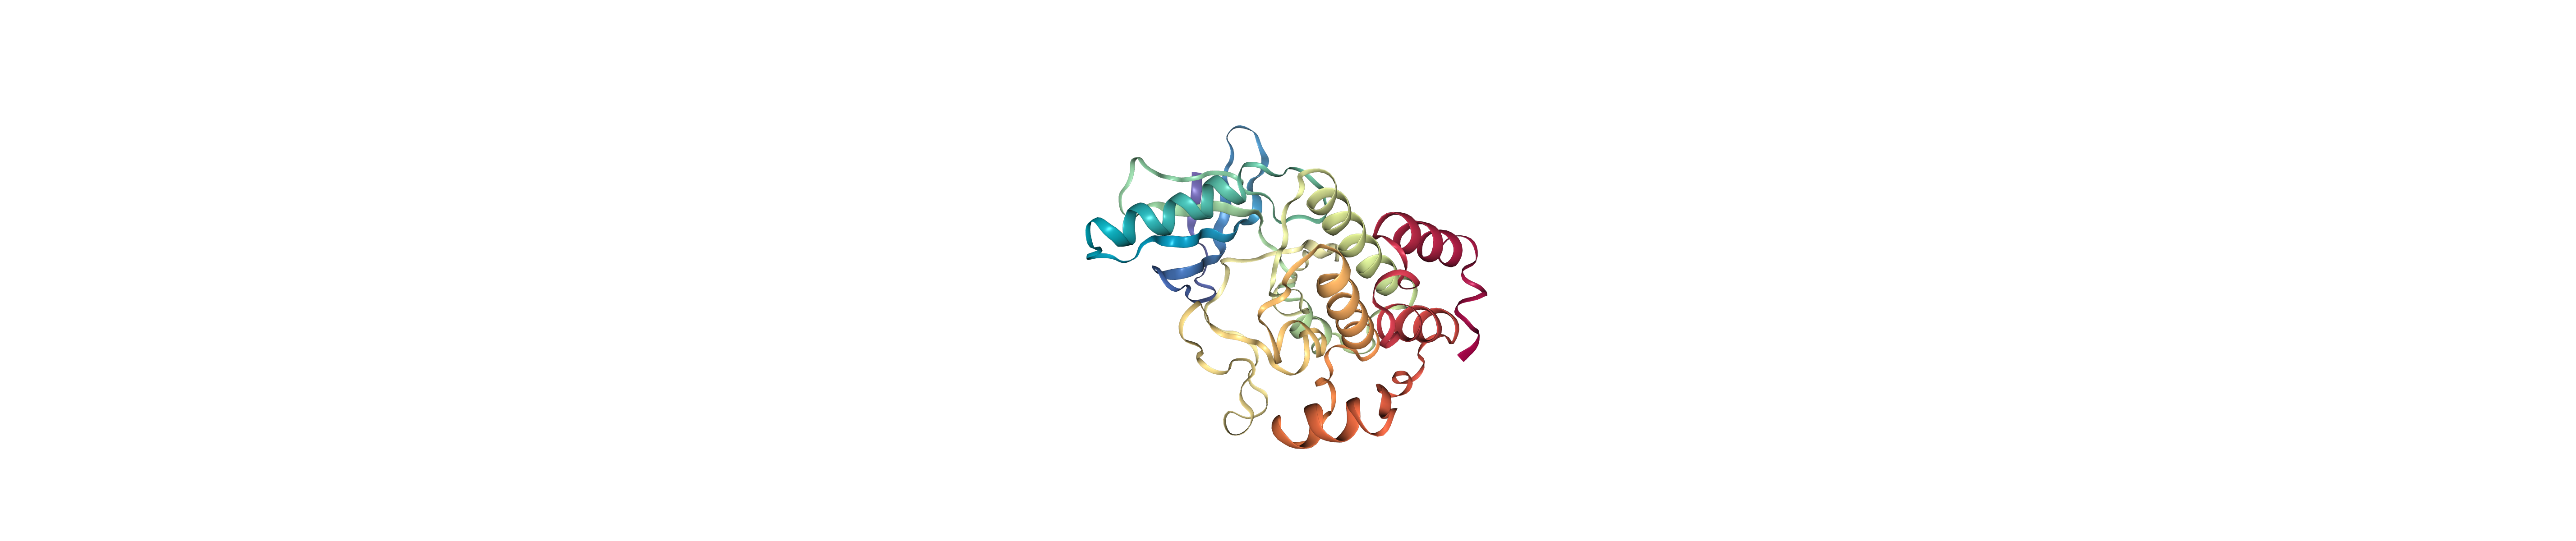

In [9]:
v._display_image()

O=C(Nc1cc2ncnc(Nc3ccccc3)c2cc1)C


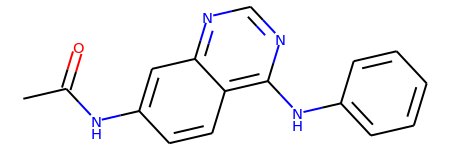

In [10]:
preview_smiles(ligands[0])

### Case study: EGFR

Adapted from [the corresponding Wikipedia article](https://en.wikipedia.org/wiki/Epidermal_growth_factor_receptor):

>The epidermal growth factor receptor (EGFR) is a member of the ErbB family of receptors, a subfamily of four closely related receptor tyrosine kinases: EGFR (ErbB-1), HER2/neu (ErbB-2), Her 3 (ErbB-3) and Her 4 (ErbB-4). In many cancer types, mutations affecting EGFR expression or activity could result in cancer.
>
>Deficient signaling of the EGFR and other receptor tyrosine kinases in humans is associated with diseases such as Alzheimer's, while over-expression is associated with the development of a wide variety of tumors. Interruption of EGFR signalling, either by blocking EGFR binding sites on the extracellular domain of the receptor or by inhibiting intracellular tyrosine kinase activity, can prevent the growth of EGFR-expressing tumours and improve the patient's condition.


As a result, we are interested in finding potential inhibitors that can target members of the EGFR family. Let's repeat the same steps as above, but now targeting this specific family.

In [11]:
egfr_molcomplex, egfr_protein, egfr_ligands = kinase_structure_from_family("EGFR")

Chosen KLIFS entry with PDB ID 3pp0 with chain A and alternate model A
Chosen ERBB2 kinase with ID 407 from family EGFR


Preview protein:

In [12]:
v = preview_molecule_contents(egfr_protein)
v

NGLWidget()

In [13]:
v.render_image();

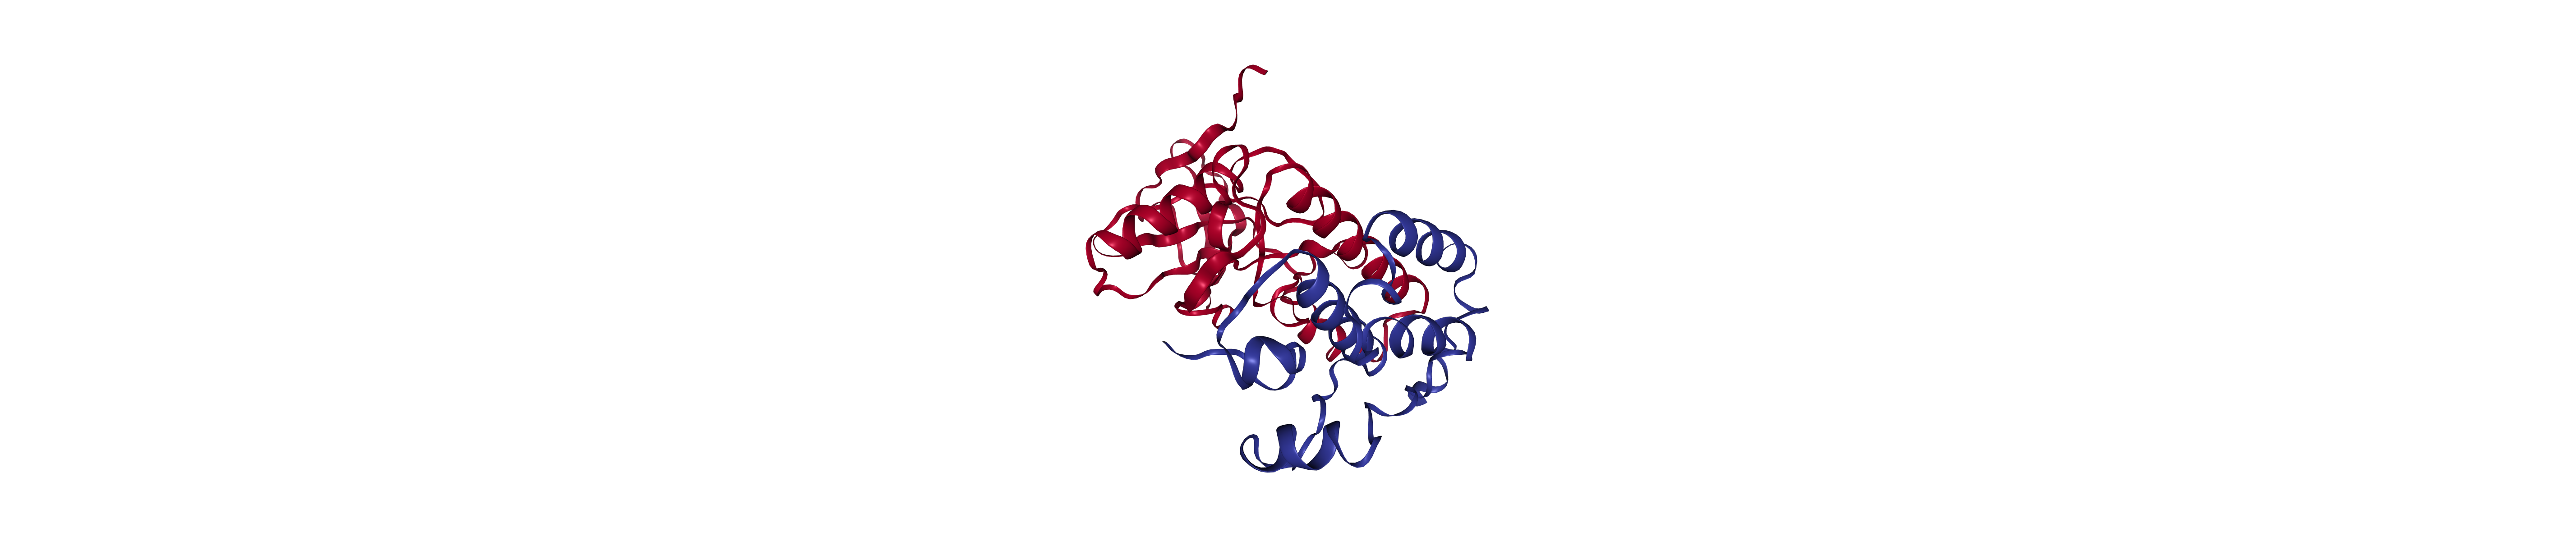

In [14]:
v._display_image()

Preview EGFR ligand (ATP):

Clc1c(Oc2cc(ccc2)C(F)(F)F)ncc(Nc3ncnc4c3N(C=C4)CCOCCO)c1


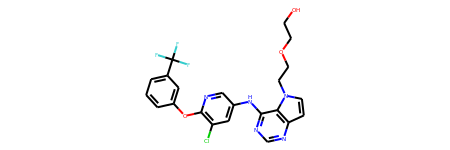

In [15]:
preview_smiles(egfr_ligands[0])

## Discussion

**TODO** Remove PubChem references.

In this notebook you have learned how to access and use different web services depending on the technologies available, from well documented API to handcrafted scrapers that try to mimic an actual web browser.

So far, we have queried the KLIFS database for members of the EGFR family, obtaining a kinase structure plus (unsurprisingly) its native ligand, the ATP. Then, PubChem has provided similar compounds with more than a 75% of similarity. We will choose one of those to perform structural modeling in the next parts.

## Quiz

- How many kinases does KLIFS provide for the "EGFR" family?
- **TODO**
- **TODO**